testing track metrics

In [1]:
import sys,os,os.path
sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize

import core.functions as func

import random



### nice functions

In [2]:

def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)






def soph_to_lowTh(df, threshold = 5, verbose = True):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process
    Made by me (John Waiton), so dont treat it like a normal function from IC!
    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''



    # new parameters for threshold, this is silly but I'm copying previous convention
    pes = 1
    threshold = threshold * pes
    same_peak = True

    # convert sophronia RECO/Events to hit collection
    soph_hitc = hits_from_df(df)

    # collect the keys as the event numbers
    soph_hitc_list = list(soph_hitc.keys())
    if (verbose == True):
        print("Processing data...")
    # loop over all of these events
    j = 0
    for i in soph_hitc_list:
        j += 1

        if (verbose == True):
            if (len(soph_hitc_list)%j == 50): 
                print("{}/{}".format(j, len(soph_hitc_list)))
        # choose i'th event
        soph_hit_event = soph_hitc.get(i)

        # Apply threshold calculation
        soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

        # convert back to pandas dataframe using hitc_to_df
        soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

        # check if pandas dataframe with all the events exists yet
        if 'full_soph_df' in locals() and isinstance(full_soph_df, pd.DataFrame):
            full_soph_df = pd.concat([full_soph_df, soph_hdst_lowTh])
        else:
            full_soph_df = soph_hdst_lowTh.copy(deep = True)
    
    return full_soph_df

In [3]:
# set the seed if you find nice events
random.seed(10)

### load in relevant sophronia file

In [4]:
file_1 = 'testing_data/sophronia_128_208Tl.h5'
file_2 = 'testing_data/sophronia_129_208Tl.h5'
file_3 = 'testing_data/sophronia_130_208Tl.h5'

In [5]:
# LOAD DATA
data = dstio.load_dst(file_1, 'RECO', 'Events')
df_ps = pd.read_hdf(file_1, 'MC/particles')

event_list = (data['event'].unique())

In [6]:
# scrape some positron events
pos_df = func.from_file_positron(file_1)

In [7]:
print("{}/{} events are signal".format(len(pos_df.index),len(event_list)))
signal_id = pos_df['event_id'].to_numpy()

53/339 events are signal


In [8]:
display(df_ps)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,1270000,1,Tl208,True,0,396.540802,394.971252,536.123352,0.000000,396.540802,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,none,RadioactiveDecay
1,1270000,4,e-,False,1,396.540802,394.971252,536.123352,0.000514,396.552490,...,0.002595,0.132775,0.439125,-0.000000,0.000000,-0.000000,0.175723,2.080215e+00,RadioactiveDecay,eIoni
2,1270000,3,anti_nu_e,False,1,396.540802,394.971252,536.123352,0.000514,-12500.000000,...,-1.443441,-0.444728,0.600621,-1.443441,-0.444728,0.600621,1.625438,1.452261e+04,RadioactiveDecay,Transportation
3,1270000,2,Pb208[3197.711],False,1,396.540802,394.971252,536.123352,0.000514,396.540802,...,1.440844,0.311953,-1.039745,0.000000,0.000000,-0.000000,0.000008,0.000000e+00,RadioactiveDecay,RadioactiveDecay
4,1270000,6,gamma,False,2,396.540802,394.971252,536.123352,0.000514,248.638458,...,-0.117886,-0.370464,0.434704,-0.000000,-0.000000,0.000000,0.583188,7.316822e+02,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27397,1270343,63,e-,False,59,383.083252,404.562683,520.891968,0.072662,383.083252,...,-0.002171,-0.000586,0.007362,0.000000,-0.000000,-0.000000,0.000058,1.447787e-07,phot,msc
27398,1270343,62,e-,False,59,383.083252,404.562683,520.891968,0.072662,383.083252,...,0.012554,-0.024946,-0.009436,0.000000,-0.000000,-0.000000,0.000850,1.402082e-05,phot,eIoni
27399,1270343,61,e-,False,59,383.083252,404.562683,520.891968,0.072662,383.083191,...,-0.063734,0.031759,0.046704,-0.000000,0.000000,-0.000000,0.007047,2.941332e-04,phot,eIoni
27400,1270343,58,e-,False,57,383.077148,404.553497,520.887756,0.072622,383.077301,...,0.108280,0.027625,-0.028822,0.000000,-0.000000,0.000000,0.012870,8.100217e-04,phot,eIoni


In [9]:
display(signal_id)

array([1270003, 1270007, 1270011, 1270017, 1270026, 1270031, 1270037,
       1270041, 1270046, 1270047, 1270049, 1270050, 1270055, 1270056,
       1270069, 1270086, 1270090, 1270107, 1270111, 1270119, 1270122,
       1270123, 1270130, 1270136, 1270138, 1270144, 1270148, 1270160,
       1270164, 1270169, 1270172, 1270174, 1270187, 1270191, 1270193,
       1270210, 1270221, 1270263, 1270265, 1270273, 1270274, 1270275,
       1270278, 1270280, 1270281, 1270291, 1270295, 1270299, 1270306,
       1270313, 1270335, 1270336, 1270339])

### lets choose some random signal events from the list

In [10]:
sig_evt_id = []

for i in range(0,5):
    sig_evt_id.append(random.choice(signal_id*2))
    print("Event chosen, ID: {}".format(sig_evt_id[i]))

Event chosen, ID: 2540442
Event chosen, ID: 2540022
Event chosen, ID: 2540320
Event chosen, ID: 2540344
Event chosen, ID: 2540442


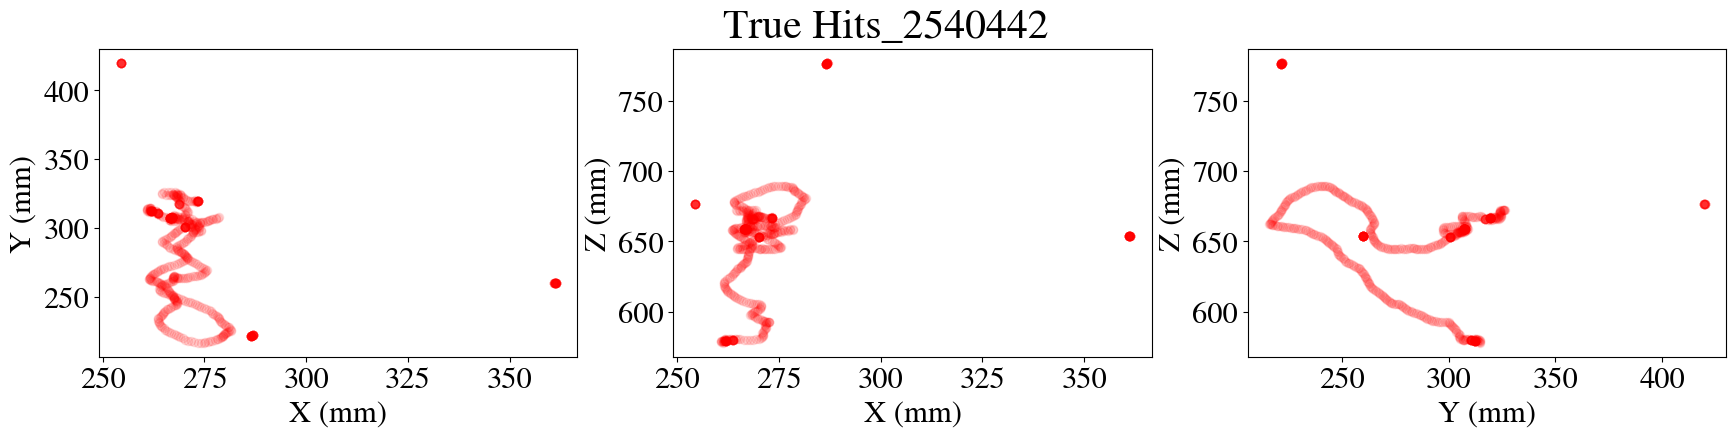

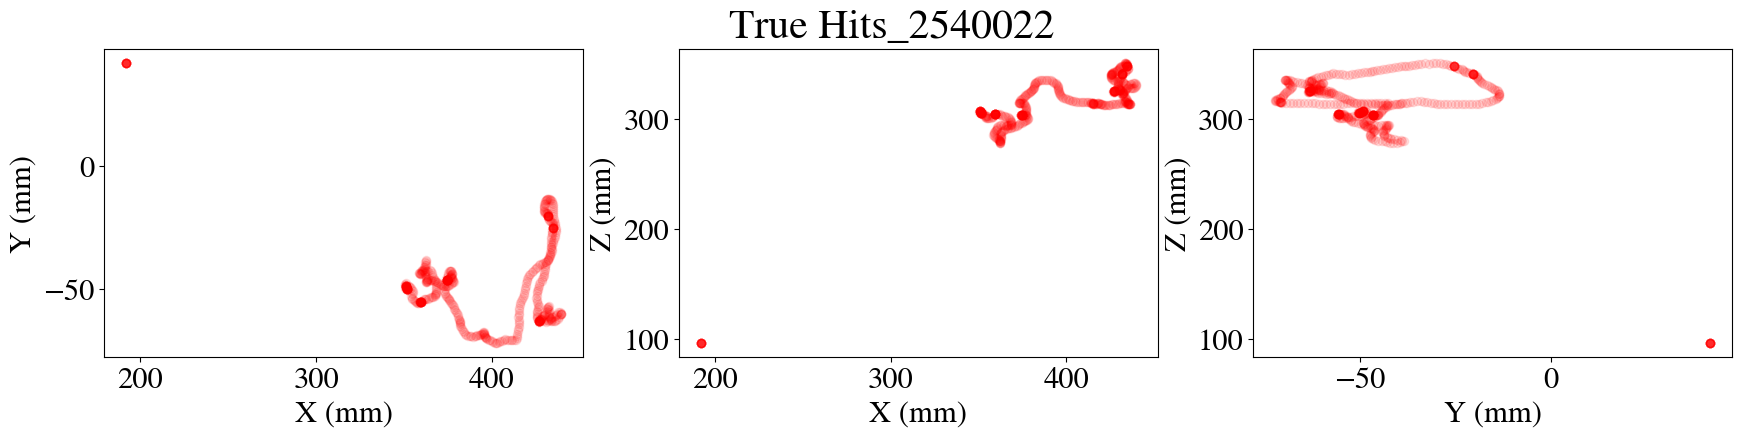

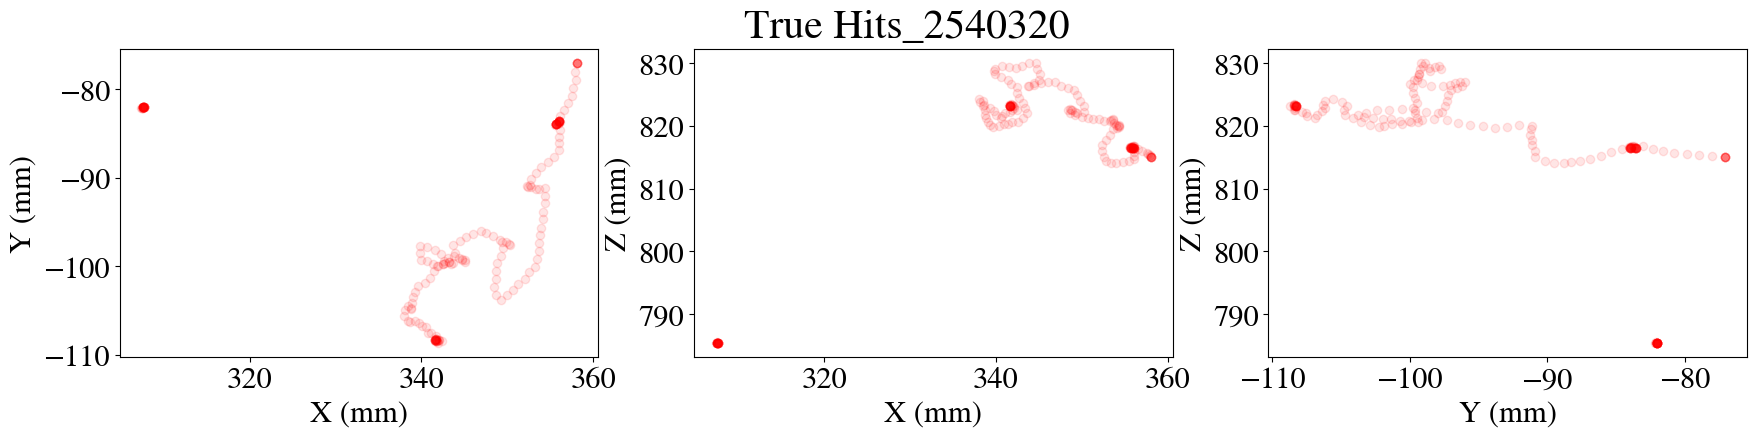

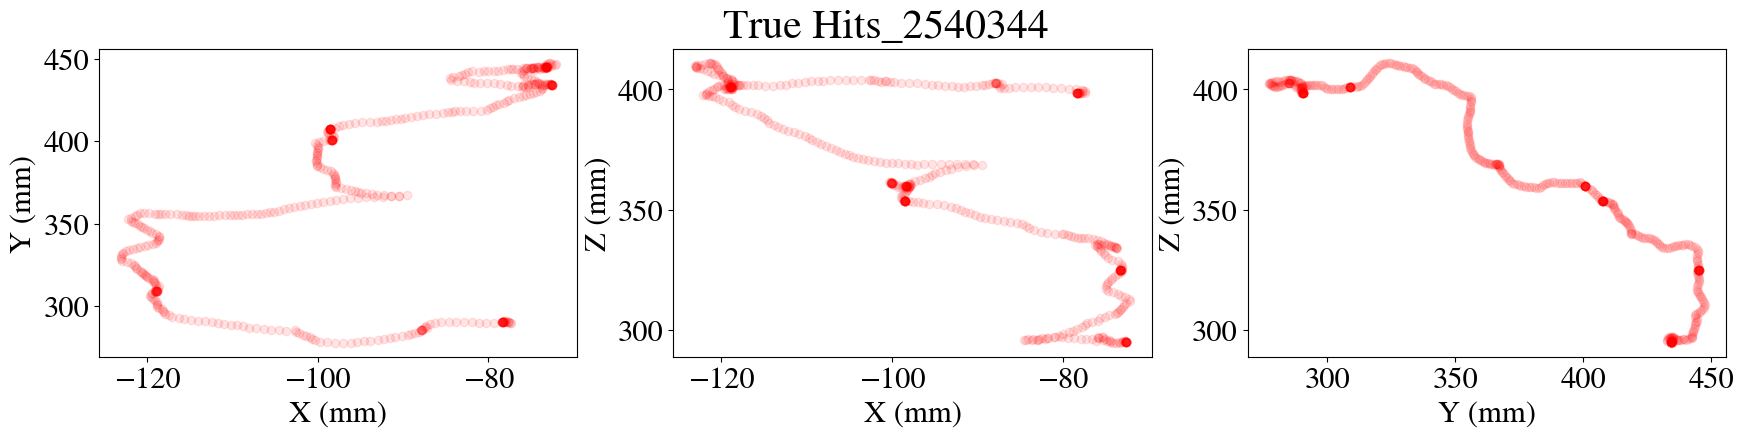

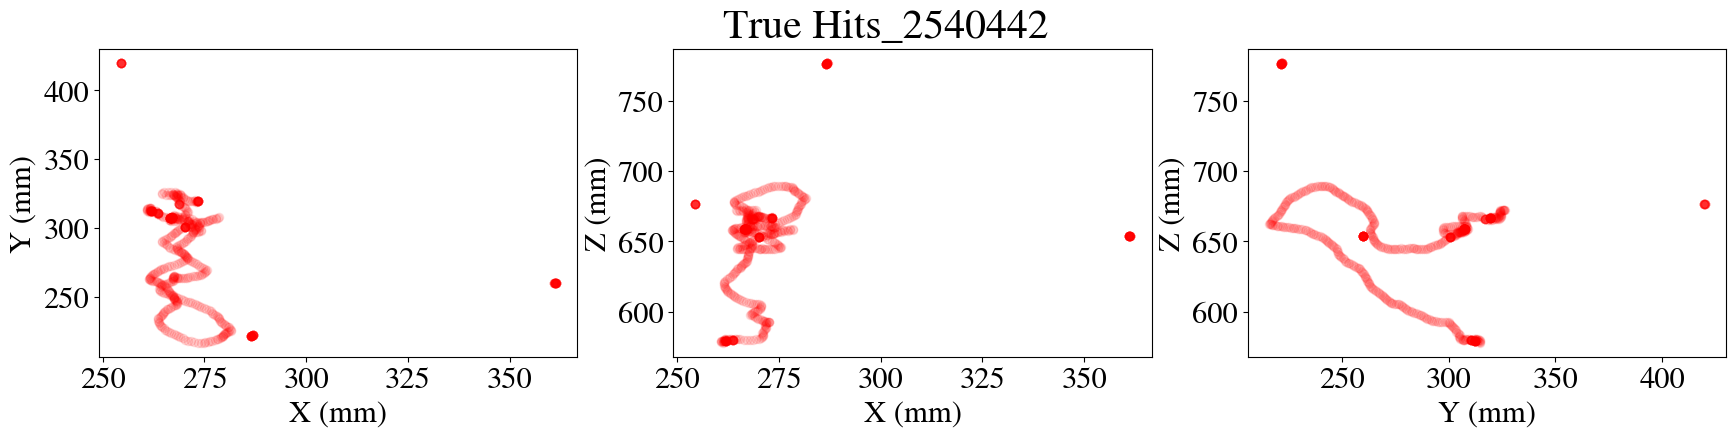

In [11]:
# Load in monte carlo for these events
for i in range(len(sig_evt_id)):

    evtmap = mcio.load_eventnumbermap(file_1).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(file_1).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
    
    this_evt_true_info = true_info[true_info.event_id == sig_evt_id[i]]

    xt = this_evt_true_info.x
    yt = this_evt_true_info.y
    zt = this_evt_true_info.z
    et = this_evt_true_info.energy*1000

    fig, axes = plt.subplots(1, 3, figsize=(21, 4))
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');

    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    
    fig.suptitle('True Hits_' + str(sig_evt_id[i]), fontsize=30)
    #fig.savefig(pre_dir_name + "/MC_hits")

### looking at the MC quickly, cause of these weird dots in the events

In [12]:
#print(checking_track.columns)

In [13]:
display(df_ps[df_ps['event_id'] == 1270003])

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
232,1270003,1,Tl208,True,0,397.771271,397.154510,537.291504,0.000000,397.771271,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,none,RadioactiveDecay
233,1270003,4,e-,False,1,397.771271,397.154510,537.291504,0.001305,394.458740,...,-0.710335,-0.486962,-0.503382,-0.000000,0.000000,-0.00000,0.609814,5.075905e+00,RadioactiveDecay,eIoni
234,1270003,3,anti_nu_e,False,1,397.771271,397.154510,537.291504,0.001305,12500.000000,...,1.077389,-0.296696,0.412950,1.077389,-0.296696,0.41295,1.191353,1.338238e+04,RadioactiveDecay,Transportation
235,1270003,2,Pb208[3197.711],False,1,397.771271,397.154510,537.291504,0.001305,397.771271,...,-0.367053,0.783657,0.090432,-0.000000,0.000000,0.00000,0.000002,0.000000e+00,RadioactiveDecay,RadioactiveDecay
236,1270003,6,gamma,False,2,397.771271,397.154510,537.291504,0.001305,407.790131,...,0.227716,-0.445658,-0.299404,0.000000,0.000000,0.00000,0.583188,3.089474e+01,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1270003,142,e-,False,136,347.174133,374.977844,533.835754,0.193354,347.174133,...,-0.030356,-0.006096,-0.001097,-0.000000,-0.000000,-0.00000,0.000938,1.463988e-05,phot,eIoni
370,1270003,141,e-,False,136,347.174133,374.977844,533.835754,0.193354,347.174133,...,0.009427,-0.005101,0.002344,0.000000,-0.000000,0.00000,0.000118,2.055104e-07,phot,msc
371,1270003,140,e-,False,136,347.174133,374.977844,533.835754,0.193354,347.174103,...,-0.052836,-0.062955,0.019098,-0.000000,-0.000000,-0.00000,0.006920,2.816402e-04,phot,eIoni
372,1270003,135,e-,False,134,347.184540,374.961273,533.827942,0.193284,347.177765,...,0.066671,-0.145126,0.363727,0.000000,-0.000000,-0.00000,0.136244,4.553174e-02,phot,eIoni


In [14]:
checking_track = df_ps[df_ps['event_id'] == 1270003]
display(checking_track[checking_track['particle_name'] == 'e+'])
posi_id = checking_track[checking_track['particle_name'] == 'e+'].particle_id.to_numpy()
#display(checking_track[checking_track['initial_x'] < -140])

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
258,1270003,30,e+,False,26,241.919312,307.031525,558.922424,0.613344,252.619385,...,-0.632811,-0.978452,-0.384404,-0.0,-0.0,0.0,0.818175,235.562592,conv,annihil


In [15]:
print("=============")
print("Initial event")
print("=============")
display(checking_track[checking_track['particle_id'] == posi_id[0]])
children_posi = checking_track[checking_track['mother_id'] == posi_id[0]]
print("=============")
print("Children of positron")
print("=============")
display(children_posi)
anihillation_gamma_ids = children_posi[children_posi['creator_proc'] == 'annihil'].particle_id.to_numpy()
for i in range(len(anihillation_gamma_ids)):
    print("=============")
    print("Children of gamma-ID: {}".format(anihillation_gamma_ids[i]))
    print("=============")
    display(checking_track[checking_track['mother_id'] == anihillation_gamma_ids[i]])



Initial event


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
258,1270003,30,e+,False,26,241.919312,307.031525,558.922424,0.613344,252.619385,...,-0.632811,-0.978452,-0.384404,-0.0,-0.0,0.0,0.818175,235.562592,conv,annihil


Children of positron


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
259,1270003,49,gamma,False,30,252.619385,185.266098,577.463013,1.511606,357.810669,...,0.090007,-0.256632,0.432618,-0.0,-0.0,0.0,0.510999,1075.065308,annihil,phot
281,1270003,48,gamma,False,30,252.619385,185.266098,577.463013,1.511606,510.825165,...,-0.090007,0.256632,-0.432618,-0.0,-0.0,0.0,0.510999,1066.626831,annihil,phot
329,1270003,47,e-,False,30,252.623566,185.232819,577.477600,1.510493,252.159088,...,-0.140553,-0.129838,0.015011,-0.0,0.0,-0.0,0.034857,1.834125,eIoni,eIoni
330,1270003,46,e-,False,30,252.614578,185.234207,577.376038,1.509603,252.614624,...,0.001751,-0.004897,0.002625,-0.0,0.0,-0.0,0.000033,0.000140,eIoni,msc
331,1270003,45,e-,False,30,252.614578,185.234207,577.376038,1.509603,252.614700,...,0.002568,-0.003546,-0.001358,0.0,-0.0,-0.0,0.000021,0.000310,eIoni,eIoni
332,1270003,44,e-,False,30,252.614578,185.234207,577.376038,1.509603,252.614487,...,-0.002345,-0.003740,0.001236,0.0,0.0,-0.0,0.000021,0.000188,eIoni,msc
333,1270003,43,e-,False,30,252.614578,185.234207,577.376038,1.509603,252.614609,...,0.001450,-0.006331,0.002166,0.0,0.0,-0.0,0.000046,0.000156,eIoni,msc
334,1270003,42,e-,False,30,252.614578,185.234207,577.376038,1.509603,252.614578,...,-0.000410,-0.002164,-0.004020,0.0,0.0,-0.0,0.000021,0.000073,eIoni,msc
335,1270003,41,e-,False,30,252.614578,185.234207,577.376038,1.509603,252.614532,...,-0.001303,-0.006524,-0.001092,-0.0,-0.0,-0.0,0.000044,0.000456,eIoni,eIoni
336,1270003,40,e-,False,30,252.614578,185.234207,577.376038,1.509603,252.614594,...,0.000504,-0.002898,-0.002010,0.0,-0.0,0.0,0.000012,0.000146,eIoni,msc


Children of gamma-ID: 49


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
260,1270003,70,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.810669,...,0.004710,-0.000165,-0.006086,0.0,-0.0,-0.0,0.000058,1.447787e-07,phot,msc
261,1270003,69,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.810669,...,-0.005725,-0.000431,-0.005156,-0.0,-0.0,-0.0,0.000058,1.450558e-07,phot,msc
262,1270003,68,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.810669,...,0.001190,0.000222,0.005708,0.0,0.0,0.0,0.000033,1.218642e-07,phot,msc
263,1270003,67,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.810669,...,-0.000504,0.007854,0.000011,-0.0,0.0,0.0,0.000061,1.473075e-07,phot,msc
264,1270003,66,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.810669,...,-0.003470,0.003113,0.003551,-0.0,0.0,0.0,0.000034,1.221262e-07,phot,msc
265,1270003,65,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.810669,...,-0.024121,-0.015280,0.003036,-0.0,-0.0,0.0,0.000806,1.365643e-05,phot,eIoni
266,1270003,64,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.810669,...,-0.006908,0.003632,-0.029046,-0.0,-0.0,-0.0,0.000884,1.045623e-05,phot,eIoni
267,1270003,63,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.810638,...,-0.015413,0.069298,-0.045606,-0.0,0.0,-0.0,0.006920,2.892444e-04,phot,eIoni
268,1270003,62,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.805908,...,-0.294170,-0.164541,0.013892,0.0,-0.0,0.0,0.101310,2.725172e-02,phot,eIoni
269,1270003,61,e-,False,49,358.978455,-302.182892,1475.545288,5.088901,358.978607,...,0.104518,-0.034193,-0.024619,0.0,-0.0,0.0,0.012278,7.228898e-04,compt,eIoni


Children of gamma-ID: 48


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
282,1270003,91,e-,False,48,510.825165,-259.136200,95.961365,5.069490,510.825165,...,0.005221,0.001577,-0.005431,0.0,0.0,-0.0,0.000058,1.447787e-07,phot,msc
283,1270003,90,e-,False,48,510.825165,-259.136200,95.961365,5.069490,510.825165,...,-0.004047,0.001572,-0.006591,-0.0,0.0,-0.0,0.000061,1.476343e-07,phot,msc
284,1270003,89,e-,False,48,510.825165,-259.136200,95.961365,5.069490,510.825165,...,-0.004349,-0.005004,-0.003948,0.0,-0.0,-0.0,0.000058,1.450558e-07,phot,msc
285,1270003,88,e-,False,48,510.825165,-259.136200,95.961365,5.069490,510.825165,...,0.022891,0.017474,-0.010454,0.0,0.0,-0.0,0.000918,1.585068e-05,phot,eIoni
286,1270003,87,e-,False,48,510.825165,-259.136200,95.961365,5.069490,510.825165,...,-0.001357,0.028154,-0.002250,-0.0,0.0,-0.0,0.000782,1.286286e-05,phot,eIoni
287,1270003,86,e-,False,48,510.825165,-259.136200,95.961365,5.069490,510.825165,...,-0.005460,-0.004832,-0.004376,-0.0,-0.0,-0.0,0.000071,1.571542e-07,phot,msc
288,1270003,85,e-,False,48,510.825165,-259.136200,95.961365,5.069490,510.825165,...,0.038429,0.074384,0.010490,0.0,0.0,0.0,0.006920,2.780227e-04,phot,eIoni
289,1270003,84,e-,False,48,510.825165,-259.136200,95.961365,5.069490,510.827148,...,-0.188838,-0.065193,-0.254859,-0.0,-0.0,0.0,0.093966,2.537613e-02,phot,eIoni
290,1270003,83,e-,False,48,511.515778,-258.799652,95.525635,5.066544,511.517883,...,0.220374,0.103671,-0.025693,0.0,0.0,0.0,0.055651,9.133794e-03,compt,eIoni
291,1270003,82,e-,False,48,500.956940,-263.725952,93.763657,5.027237,500.955475,...,-0.026849,-0.252058,-0.078805,0.0,-0.0,-0.0,0.064835,1.236313e-02,compt,eIoni


In [16]:
pd.set_option('display.max_columns', None)

double_escape_IDs = []

for i in range(len(signal_id)):
    # select specific event
    signal_data = pos_df[pos_df['event_id'] == signal_id[i]]
    #display(signal_data)
    df_ps_data = df_ps[df_ps['event_id'] == signal_id[i]]
    mother_id_pos = signal_data.particle_id.to_numpy()[0]
    positron_children = df_ps_data[df_ps_data['mother_id'] == mother_id_pos]
    #display(positron_children)
    # collect the annihilation gammas
    annihilation_gamma_id = positron_children[positron_children['creator_proc'] == 'annihil'].particle_id.to_numpy()
    #display(annihilation_gamma_id)
    for j in range(len(annihilation_gamma_id)):
        # check the two gammas children, they better not exist
        gamma_children = (df_ps_data[df_ps_data['mother_id'] == annihilation_gamma_id[j]])
        #display(gamma_children)
        # check that no events occur from the children within ACTIVE
        gamma_active = gamma_children[gamma_children['final_volume'] == 'ACTIVE']
        if len(gamma_active.index) == 0:
            double_escape_IDs.append(signal_id[i])
        else:
            #print("Event {} not double-photo, remove...".format(signal_id[i]))
            # kill it
            if (j == 0):
                break
            elif (j == 1):
                # remove previous double_escape_ID event from list
                double_escape_IDs.remove(signal_id[i])



double_escape_IDs = np.unique(np.array(double_escape_IDs))
    
    

In [17]:
print("{}/{} events with double photo-escape".format(len(double_escape_IDs), len(signal_id)))
print("")
print("{:.2f}% of events within file are signal events\n      within our energy region".format((len(double_escape_IDs)/len(event_list))*100))

30/53 events with double photo-escape

8.85% of events within file are signal events
      within our energy region


In [18]:
# lets try reading in all the data and collecting the number of events

X = func.numb_of_signal_events('../FOM_merge&fit/12_12_18/PORT_1a/isaura/')
X = func.numb_of_signal_events('../FOM_merge&fit/12_12_18/PORT_1b/isaura/')
X = func.numb_of_signal_events('../FOM_merge&fit/12_12_18/PORT_2a/isaura/')
X = func.numb_of_signal_events('../FOM_merge&fit/12_12_18/PORT_2b/isaura/')

100%|██████████| 300/300 [01:33<00:00,  3.20it/s]


6940/100009 events with double photo-escape

6.94% of events within file are signal events
      within our energy region


100%|██████████| 300/300 [01:25<00:00,  3.53it/s]


6611/95550 events with double photo-escape

6.92% of events within file are signal events
      within our energy region


100%|██████████| 300/300 [01:00<00:00,  4.92it/s]


5284/71042 events with double photo-escape

7.44% of events within file are signal events
      within our energy region


100%|██████████| 300/300 [01:21<00:00,  3.68it/s]

6800/95440 events with double photo-escape

7.12% of events within file are signal events
      within our energy region


### trying with fiducial cuts applied now

In [19]:
#X = func.numb_of_signal_events('../FOM_merge&fit/12_12_18/PORT_1a/isaura/', fid = True)
#X = func.numb_of_signal_events('../FOM_merge&fit/12_12_18/PORT_1b/isaura/', fid = True)
#X = func.numb_of_signal_events('../FOM_merge&fit/12_12_18/PORT_2a/isaura/', fid = True)
#X = func.numb_of_signal_events('../FOM_merge&fit/12_12_18/PORT_2b/isaura/', fid = True)

100%|██████████| 300/300 [01:57<00:00,  2.56it/s]


0/100009 events with double photo-escape

0.00% of events within file are signal events
      within our energy region


100%|██████████| 300/300 [02:05<00:00,  2.38it/s]


0/95550 events with double photo-escape

0.00% of events within file are signal events
      within our energy region


100%|██████████| 300/300 [01:25<00:00,  3.52it/s]


0/71042 events with double photo-escape

0.00% of events within file are signal events
      within our energy region


 86%|████████▌ | 258/300 [01:37<00:15,  2.65it/s]


KeyboardInterrupt: 

In [ ]:
true_info = mcio.load_mchits_df(file_1).reset_index()
one_event = true_info[true_info.event_id == 1270000]
display(one_event)

z_min = np.min(one_event.z.to_numpy())
print(z_min)

,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,1270000,6,0,248.638458,-69.822289,1081.513794,2.441143,0.000094,ACTIVE
1,1270000,12,0,248.638657,-69.822350,1081.513672,2.441205,0.000034,ACTIVE
2,1270000,11,0,248.638474,-69.822372,1081.513794,2.441175,0.000021,ACTIVE
3,1270000,10,0,248.638580,-69.822090,1081.513672,2.441193,0.000067,ACTIVE
4,1270000,9,0,248.638275,-69.822052,1081.513916,2.441163,0.000017,ACTIVE
...,...,...,...,...,...,...,...,...,...
275,1270000,28,48,35.870018,-423.493622,411.440063,4.029130,0.001573,ACTIVE
276,1270000,28,49,35.872967,-423.506439,411.433502,4.029427,0.003183,ACTIVE
277,1270000,28,50,35.874050,-423.507477,411.427277,4.029600,0.000423,ACTIVE
278,1270000,28,51,35.879116,-423.508057,411.429199,4.029756,0.002179,ACTIVE


400.19904
